In [86]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
import os
from pathlib import Path
import glob
from random import shuffle
import re
import cv2 as cv
import keras
import tensorflow as tf
from keras.utils import load_img, img_to_array
from PIL import Image, ImageChops
from keras.preprocessing.image import ImageDataGenerator
import random
import shutil
from sklearn.model_selection import train_test_split

# Load VGG16 model

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Model
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import BatchNormalization

from sklearn.metrics import classification_report,confusion_matrix

# Load ResNet50 model
from keras.applications import ResNet50

# Load InceptionV3 model
from keras.applications.inception_v3 import InceptionV3

In [87]:
# Size of the output images (after resizing) and number of channels
output_image_size = (224, 224)
output_image_chanels = 3
output_image_shape = (output_image_size[0], output_image_size[1], 3)

In [88]:
print(Path.cwd())
if not os.path.exists('input'):
    # Import dataset
    os.chdir("../")
    print(Path.cwd())
    print(os.listdir())

c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection


In [89]:
input_data = Path('input/chest_xray/chest_xray')

train_directory = input_data / 'train'
test_directory = input_data / 'test'
validation_directory = input_data / 'val'

train_normal_directory = train_directory / 'NORMAL'
train_pneumonia_directory = train_directory / 'PNEUMONIA'

test_normal_directory = test_directory / 'NORMAL'
test_pneumonia_directory = test_directory / 'PNEUMONIA'

validation_normal_directory = validation_directory / 'NORMAL'
validation_pneumonia_directory = validation_directory / 'PNEUMONIA'

print(train_normal_directory)
print(test_normal_directory)
print(validation_normal_directory)

input\chest_xray\chest_xray\train\NORMAL
input\chest_xray\chest_xray\test\NORMAL
input\chest_xray\chest_xray\val\NORMAL


In [90]:
def images_and_labels(list_of_directories: list, label):
    list_of_images = []
    for directory in list_of_directories:
        for img in directory.glob('*.jpeg'):
            if re.search('virus', img.name.lower()):
                list_of_images.append((os.path.abspath(img), 'virus', label))

            elif re.search('bacteria', img.name.lower()):
                list_of_images.append((os.path.abspath(img), 'bacteria', label))
            else:
                list_of_images.append((os.path.abspath(img), 'normal', label))

    return list_of_images

In [91]:
# normal cases are labeled 0
list_of_normal_cases = images_and_labels([train_normal_directory, 
                                          test_normal_directory, validation_normal_directory], 0)

# pneumonia cases are labeled 1
list_of_pneumonia_cases = images_and_labels([train_pneumonia_directory, 
                                             test_pneumonia_directory, validation_pneumonia_directory], 1)

random.seed(42)
random.shuffle(list_of_normal_cases)
random.shuffle(list_of_pneumonia_cases)

In [92]:
print(len(list_of_normal_cases), len(list_of_pneumonia_cases), "\n")
print(list_of_normal_cases[0], "\n", list_of_pneumonia_cases[0], "\n")
print(len(list_of_normal_cases[0]))

1583 4273 

('c:\\Users\\rasul.osmanbayli\\From Github\\Pneumonia-Detection\\input\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0702-0001.jpeg', 'normal', 0) 
 ('c:\\Users\\rasul.osmanbayli\\From Github\\Pneumonia-Detection\\input\\chest_xray\\chest_xray\\train\\PNEUMONIA\\person433_bacteria_1875.jpeg', 'bacteria', 1) 

3


In [93]:
# Create dataframe
df = pd.DataFrame(list_of_normal_cases + list_of_pneumonia_cases, columns=['image', 'description', 'label'])

In [94]:
# get statistics of the dataframe
print(df.head())

                                               image description  label
0  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
1  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
2  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
3  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
4  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0


In [95]:
print(df.tail())

                                                  image description  label
5851  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
5852  c:\Users\rasul.osmanbayli\From Github\Pneumoni...       virus      1
5853  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
5854  c:\Users\rasul.osmanbayli\From Github\Pneumoni...       virus      1
5855  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1


In [96]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        5856 non-null   object
 1   description  5856 non-null   object
 2   label        5856 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 137.4+ KB
None


In [97]:
print(df.describe())

             label
count  5856.000000
mean      0.729679
std       0.444164
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


In [98]:
print(df['label'].value_counts())

label
1    4273
0    1583
Name: count, dtype: int64


In [99]:
print(df['label'].value_counts(normalize=True))

label
1    0.729679
0    0.270321
Name: proportion, dtype: float64


In [100]:
print(df['description'].value_counts())

description
bacteria    2780
normal      1583
virus       1493
Name: count, dtype: int64


In [101]:
print(df['description'].value_counts(normalize=True))

description
bacteria    0.474727
normal      0.270321
virus       0.254952
Name: proportion, dtype: float64


In [102]:
print(df.isnull().sum())

image          0
description    0
label          0
dtype: int64


In [103]:
print(df.isna().sum())

image          0
description    0
label          0
dtype: int64


In [104]:
print(df.sample(5))

                                                  image description  label
3487  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
3068  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
981   c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
3233  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
4626  c:\Users\rasul.osmanbayli\From Github\Pneumoni...       virus      1


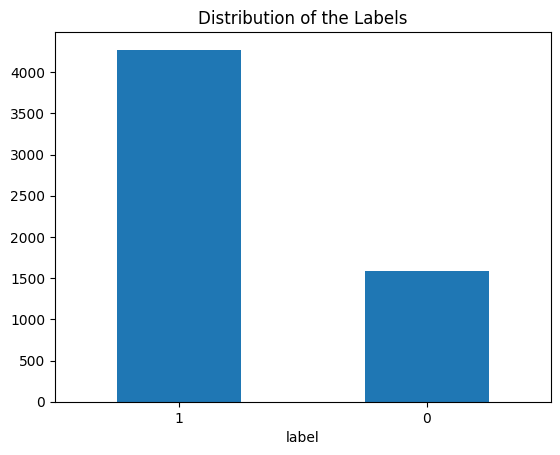

In [105]:
# Plot the distribution of the labels
df['label'].value_counts().plot(kind='bar', rot=0)
plt.title('Distribution of the Labels')
plt.show()

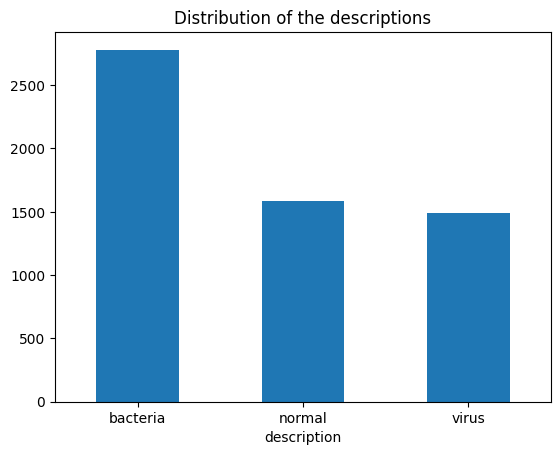

In [106]:
# Plot the distribution of the descriptions
df['description'].value_counts().plot(kind='bar', rot=0)
plt.title('Distribution of the descriptions')
plt.show()

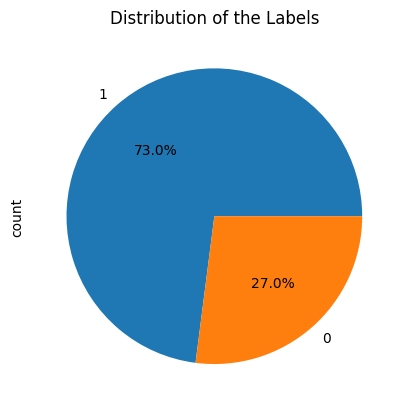

In [107]:
# Pie chart of the distribution of the labels
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of the Labels')
plt.show()

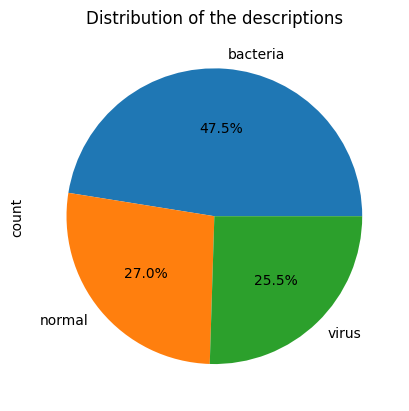

In [108]:
# Pie chart of the distribution of the descriptions
df['description'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of the descriptions')
plt.show()

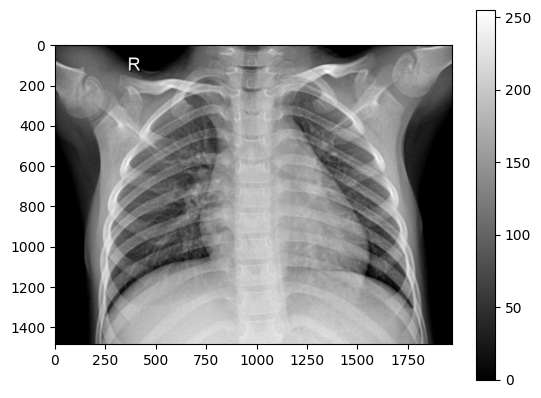

In [109]:
# Pixel distribution of the images
img = plt.imread(df['image'][0])
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

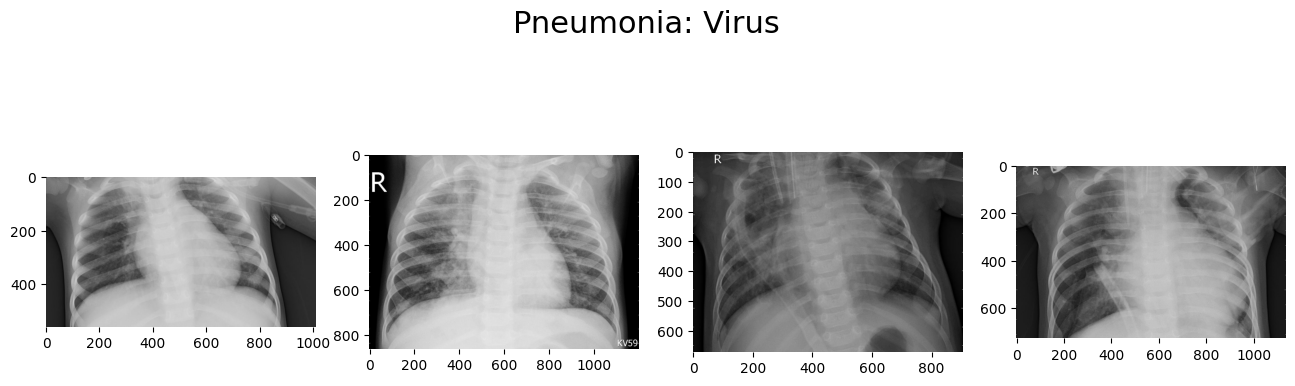

In [110]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Pneumonia: Virus', size=22)

for i, img in enumerate(df[df['description'] == 'virus']['image'][:4]):
    img = plt.imread(img)
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img, cmap='gray')
plt.show()

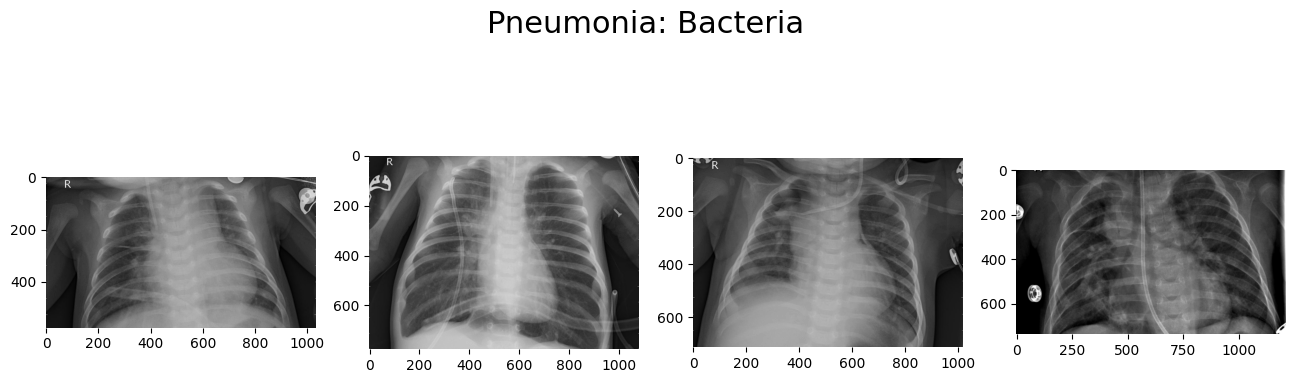

In [111]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Pneumonia: Bacteria', size=22)

for i, img in enumerate(df[df['description'] == 'bacteria']['image'][:4]):
    img = plt.imread(img)
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img, cmap='gray')
plt.show()

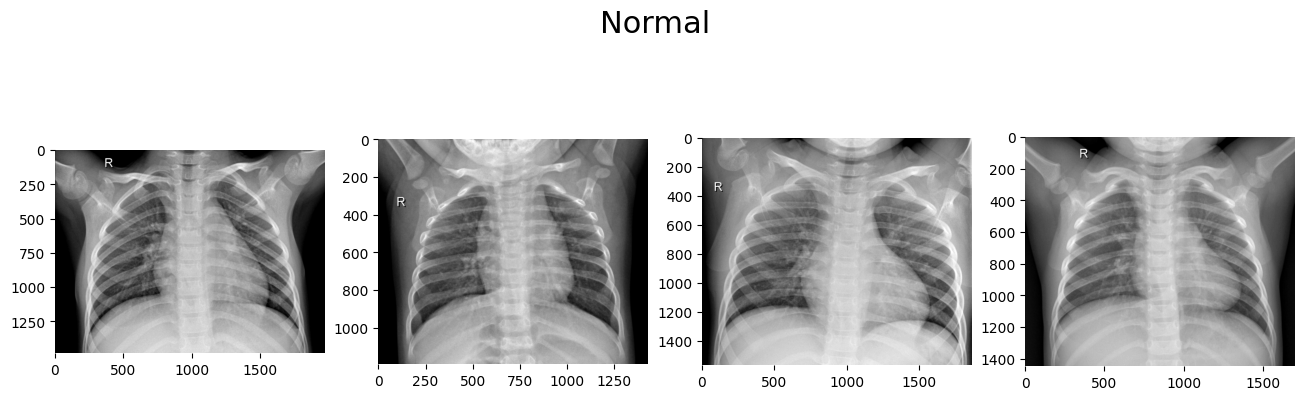

In [112]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Normal', size=22)

for i, img in enumerate(df[df['description'] == 'normal']['image'][:4]):
    img = plt.imread(img)
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img, cmap='gray')
plt.show()

In [113]:
def resize_images(input_list: list, size_of_images: tuple):

    if input_list == []:
        print("Input list is empty")
        return

    if size_of_images[0] <= 0 or size_of_images[1] <= 0:
        print("Size of images is invalid")
        return
    
    if len(input_list[0]) != 3:
        print("Input list elements should have 3 attributes")
        return

    resized_images = []
    errors = []
    for i in range(len(input_list)):
        try:
            img_array = cv.imread(input_list[i][0], cv.IMREAD_GRAYSCALE)
            
            if output_image_chanels == 3:
                img_array = cv.cvtColor(img_array, cv.COLOR_GRAY2RGB)

            resized_image = cv.resize(img_array, size_of_images)
            resized_images.append([resized_image, input_list[i][1], input_list[i][2]])
        except Exception as e:
            print(e)
            errors.append([input_list[i][0], input_list[i][1], input_list[i][2]])
            resized_images.append([None, input_list[i][1], input_list[i][2]])
            continue 
    
    
    print("Resizing finished")
    print("Number of images: ", len(resized_images))
    print("Shape of images: ", resized_images[0][0].shape)
    print("Number of errors: ", len(errors))
    print("Errors: ", errors)

    for i in range(len(errors)):
        print(errors[i][0], errors[i][1], errors[i][2])

    return resized_images

In [114]:
print(list_of_normal_cases[0][0])
print(list_of_normal_cases[0][1])
print(list_of_normal_cases[0][2])

normal_cases = resize_images(list_of_normal_cases, output_image_size)
pneumonia_cases = resize_images(list_of_pneumonia_cases, output_image_size)

c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray\chest_xray\train\NORMAL\IM-0702-0001.jpeg
normal
0
Resizing finished
Number of images:  1583
Shape of images:  (224, 224, 3)
Number of errors:  0
Errors:  []
Resizing finished
Number of images:  4273
Shape of images:  (224, 224, 3)
Number of errors:  0
Errors:  []


In [115]:
print(normal_cases[0][1])
print(normal_cases[0][2])

normal
0


In [116]:
resized_images_directory = Path('input/chest_xray_resized').absolute()
resized_images_directory.mkdir(exist_ok=True)

normal_resized_directory = resized_images_directory / 'Normal'
normal_resized_directory.mkdir(exist_ok=True)

pneumonia_resized_directory = resized_images_directory / 'Pneumonia'
pneumonia_resized_directory.mkdir(exist_ok=True)

In [117]:
print("normal_dir: ", normal_resized_directory)
print("pneumonia_dir: ", pneumonia_resized_directory)
print(f"{normal_resized_directory}/{normal_cases[0][1]}_{normal_cases[0][2]}.jpeg")
print(len(normal_cases))
print(f"{pneumonia_resized_directory}/{pneumonia_cases[0][1]}_{pneumonia_cases[0][2]}.jpeg")

normal_dir:  c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized\Normal
pneumonia_dir:  c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized\Pneumonia
c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized\Normal/normal_0.jpeg
1583
c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized\Pneumonia/bacteria_1.jpeg


In [118]:
for i in range(len(normal_cases)):
    if not cv.imwrite(f"{normal_resized_directory}\IMG{i}_{normal_cases[i][1]}_{normal_cases[i][2]}.jpeg", normal_cases[i][0]):
        raise Exception(f"Could not write image: {normal_resized_directory}\IMG{i}_{normal_cases[i][1]}_{normal_cases[i][2]}.jpeg")

In [119]:
for i in range(len(pneumonia_cases)):
    if not cv.imwrite(f"{pneumonia_resized_directory}\IMG{i}_{pneumonia_cases[i][1]}_{pneumonia_cases[i][2]}.jpeg", pneumonia_cases[i][0]):
        raise Exception(f"Could not write image: {pneumonia_resized_directory}\IMG{i}_{pneumonia_cases[i][1]}_{pneumonia_cases[i][2]}.jpeg")

In [120]:
list_of_normal_cases_resized = images_and_labels([normal_resized_directory], 0)

# pneumonia cases are labeled 1
list_of_pneumonia_cases_resized = images_and_labels([pneumonia_resized_directory], 1)

print("Number of normal cases: ", len(list_of_normal_cases_resized))
print("Number of pneumonia cases: ", len(list_of_pneumonia_cases_resized))

Number of normal cases:  1583
Number of pneumonia cases:  4273


In [121]:
# Create dataframe from resized images
df_new = pd.DataFrame(list_of_normal_cases_resized + list_of_pneumonia_cases_resized, columns=['image', 'description', 'label'])

In [122]:
print(df_new.head())

                                               image description  label
0  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
1  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
2  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
3  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
4  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0


In [123]:
print(df_new.tail())

                                                  image description  label
5851  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
5852  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
5853  c:\Users\rasul.osmanbayli\From Github\Pneumoni...       virus      1
5854  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
5855  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1


In [124]:
print(df_new.sample(5))

                                                  image description  label
1068  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
4974  c:\Users\rasul.osmanbayli\From Github\Pneumoni...    bacteria      1
4049  c:\Users\rasul.osmanbayli\From Github\Pneumoni...       virus      1
1570  c:\Users\rasul.osmanbayli\From Github\Pneumoni...      normal      0
3061  c:\Users\rasul.osmanbayli\From Github\Pneumoni...       virus      1


In [125]:
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        5856 non-null   object
 1   description  5856 non-null   object
 2   label        5856 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 137.4+ KB
None


In [126]:
print(df_new.describe())

             label
count  5856.000000
mean      0.729679
std       0.444164
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


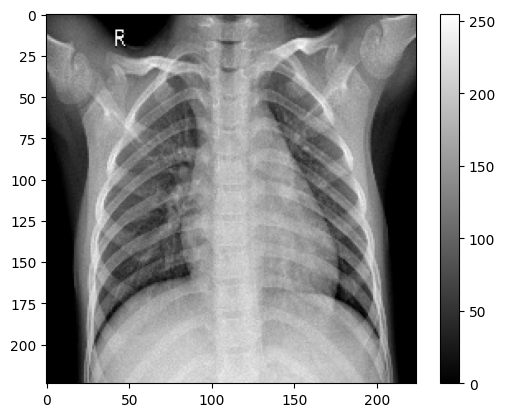

In [127]:
# Pixel distribution of the images
img = plt.imread(df_new['image'][0])
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

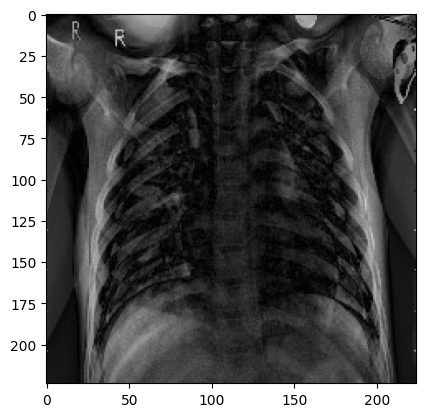

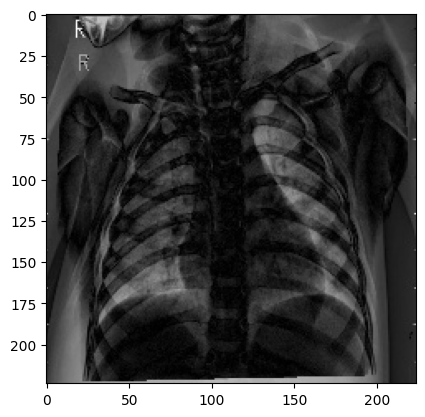

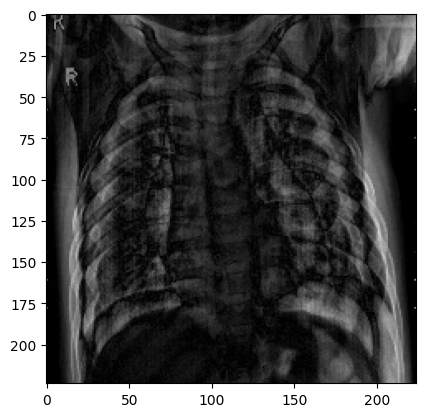

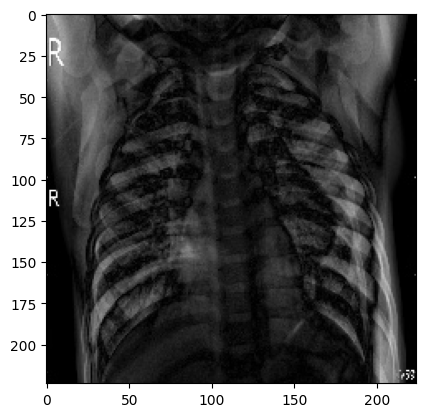

In [128]:
# Finding difference between the normal and pneumonia cases
diff_directory = Path('input/diff_images').absolute()
diff_directory.mkdir(exist_ok=True)

for i in range(4):
    img1 = Image.open(list_of_normal_cases_resized[i][0])
    img2 = Image.open(list_of_pneumonia_cases_resized[i][0])

    diff = ImageChops.difference(img1, img2)

    diff.save(f"{diff_directory}/diff{i}.png")
    plt.imshow(plt.imread(f"{diff_directory}/diff{i}.png"))
    plt.show()

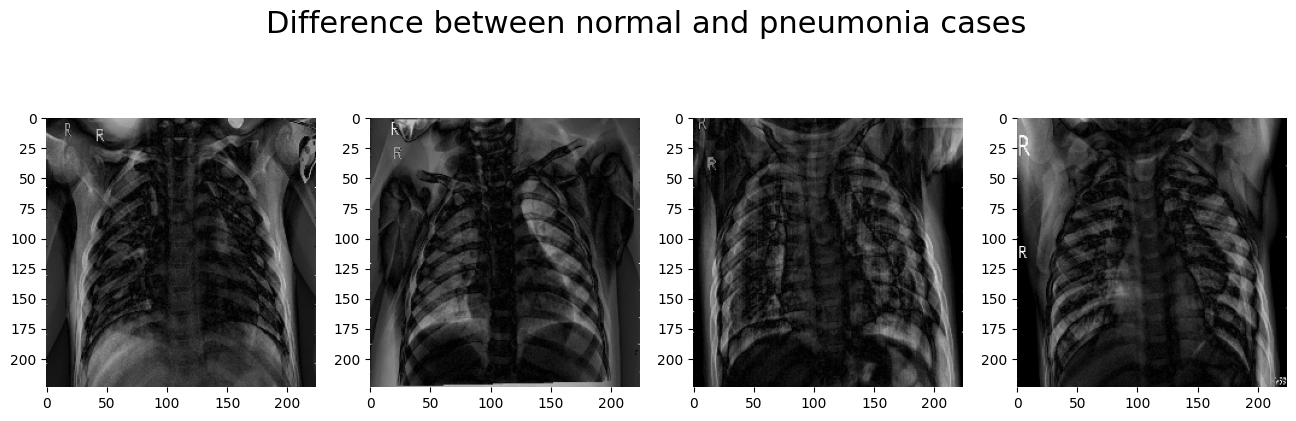

In [129]:
# Show a subplot of 4 images with differences between normal and pneumonia cases
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Difference between normal and pneumonia cases', size=22)

for i, img in enumerate(os.listdir(diff_directory)[:4]):
    img = plt.imread(diff_directory / img)
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img)
plt.show()

In [130]:
def show_pixel_distribution(sample_normal_img, title, combined=False):

    sns.distplot(sample_normal_img.ravel(),
                label=f"Pixel Mean {np.mean(sample_normal_img):.4f} and Standard Deviation {np.std(sample_normal_img):.4f}", kde=False)
    plt.legend(loc='upper center')
    plt.title(f'Distribution of Pixel Intensities in the {title} Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')

    if not combined:
        plt.show()

<ipython-input-130-9ac716c34f12>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_normal_img.ravel(),


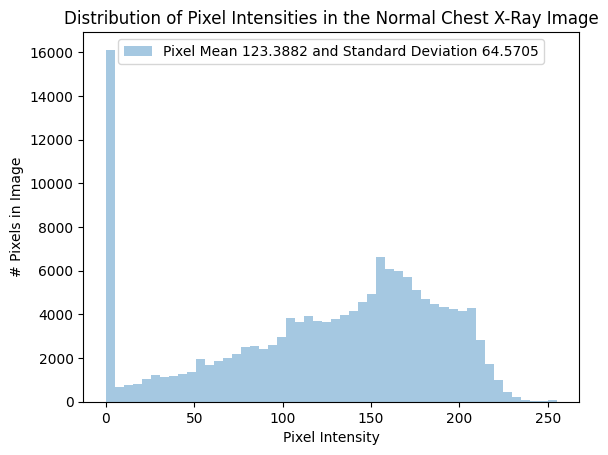

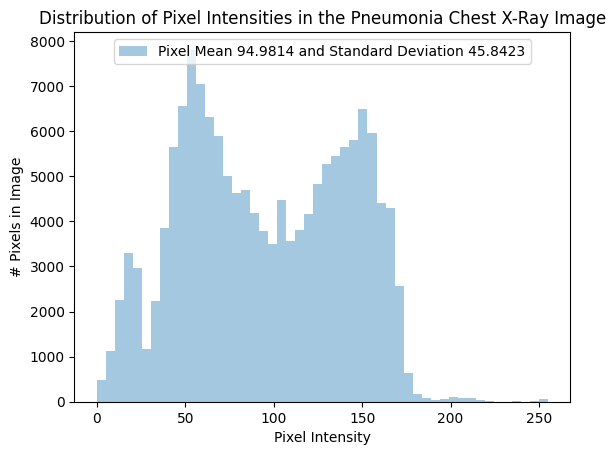

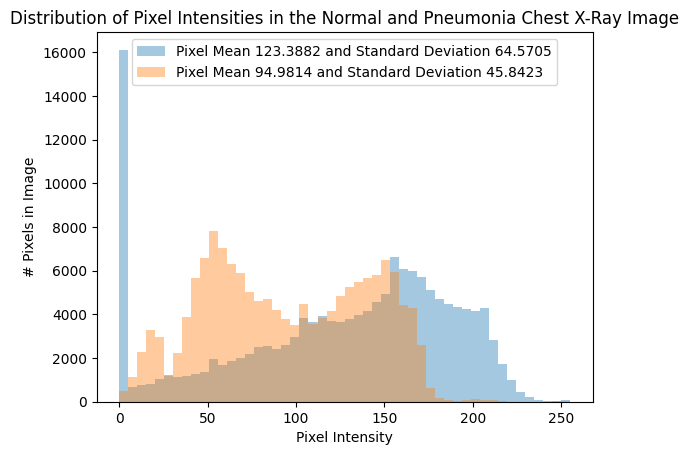

In [131]:
sample_normal_img = plt.imread(list_of_normal_cases_resized[0][0])
sample_pneumonia_img = plt.imread(list_of_pneumonia_cases_resized[0][0])

show_pixel_distribution(sample_normal_img, 'Normal Chest X-Ray')
show_pixel_distribution(sample_pneumonia_img, 'Pneumonia Chest X-Ray')


show_pixel_distribution(sample_normal_img, 'Normal and Pneumonia Chest X-Ray', combined=True)
show_pixel_distribution(sample_pneumonia_img, 'Normal and Pneumonia Chest X-Ray', combined=True)
plt.show()

In [132]:
# Augmenting normal images
normal_augmented_directory = resized_images_directory / 'Normal_Augmented'
normal_augmented_directory.mkdir(exist_ok=True)
print(normal_augmented_directory)

image_generator = ImageDataGenerator(rotation_range=10, 
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1, 
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     samplewise_center=True,
                                     samplewise_std_normalization=True)

c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized\Normal_Augmented


In [133]:
print(normal_resized_directory)
path = Path(normal_resized_directory).parent.absolute()
print(path)

c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized\Normal
c:\Users\rasul.osmanbayli\From Github\Pneumonia-Detection\input\chest_xray_resized


In [134]:
# Augmenting normal images
# You need to put normal image folder inside a normal_augmented_directory
# because generator looks for the folder inside the directory

# Copy normal images folder to normal_augmented_directory
shutil.copytree(normal_resized_directory, normal_augmented_directory / 'Normal', dirs_exist_ok=True)

WindowsPath('c:/Users/rasul.osmanbayli/From Github/Pneumonia-Detection/input/chest_xray_resized/Normal_Augmented/Normal')

In [135]:
normal_generated = image_generator.flow_from_directory(
    normal_augmented_directory,
    batch_size=20,
    save_to_dir=normal_augmented_directory,
    save_prefix='aug_',
    save_format='jpeg',
    class_mode='input',
    shuffle=True,
    target_size=output_image_size
)

Found 1583 images belonging to 1 classes.


In [136]:
normal_generated.next()

(array([[[[-0.79868203, -0.79868203, -0.79868203],
          [-0.7954416 , -0.7954416 , -0.7954416 ],
          [-0.79220116, -0.79220116, -0.79220116],
          ...,
          [-0.7758071 , -0.7758071 , -0.7758071 ],
          [-0.7144067 , -0.7144067 , -0.7144067 ],
          [-0.7144067 , -0.7144067 , -0.7144067 ]],
 
         [[-0.8702444 , -0.8702444 , -0.8702444 ],
          [-0.8637635 , -0.8637635 , -0.8637635 ],
          [-0.85728276, -0.85728276, -0.85728276],
          ...,
          [-0.7652026 , -0.7652026 , -0.7652026 ],
          [-0.7144067 , -0.7144067 , -0.7144067 ],
          [-0.7144067 , -0.7144067 , -0.7144067 ]],
 
         [[-0.92570335, -0.92570335, -0.92570335],
          [-0.9229617 , -0.9229617 , -0.9229617 ],
          [-0.91810113, -0.91810113, -0.91810113],
          ...,
          [-0.75459826, -0.75459826, -0.75459826],
          [-0.7144067 , -0.7144067 , -0.7144067 ],
          [-0.7144067 , -0.7144067 , -0.7144067 ]],
 
         ...,
 
         [[-

In [137]:
# Removing normal images from normal_augmented_directory
shutil.rmtree(normal_augmented_directory / 'Normal')

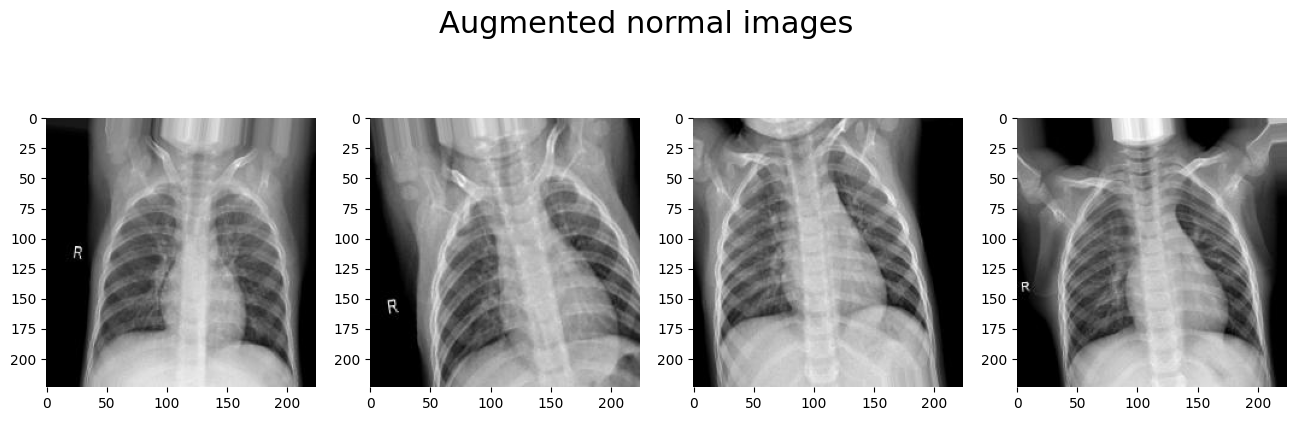

In [138]:
# Show augmented images
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Augmented normal images', size=22)

for i, img in enumerate(os.listdir(normal_augmented_directory)[:4]):
    img = plt.imread(normal_augmented_directory / img)
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img, cmap='gray')
plt.show()

In [139]:
def load_image_as_np_array(img_url):
    img = cv.imread(img_url)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, output_image_size)
    img = img.astype('float32')
    img /= 255
    return img

In [140]:
# Create train and test data

# from images to RGB numpy array 
list_of_normal_cases_resized_images_np = list()
list_of_normal_cases_resized_labels_np = list()
for i in range(len(list_of_normal_cases_resized)):
    list_of_normal_cases_resized_images_np.append(load_image_as_np_array(list_of_normal_cases_resized[i][0]))
    list_of_normal_cases_resized_labels_np.append(list_of_normal_cases_resized[i][2])

list_of_pneumonia_cases_resized_images_np = list()
list_of_pneumonia_cases_resized_labels_np = list()

for i in range(len(list_of_pneumonia_cases_resized)):
    
    list_of_pneumonia_cases_resized_images_np.append(load_image_as_np_array(list_of_pneumonia_cases_resized[i][0]))
    list_of_pneumonia_cases_resized_labels_np.append(list_of_pneumonia_cases_resized[i][2])

print(f"length of image list of normal cases: {len(list_of_normal_cases_resized_images_np)}", f"length of labels of normal cases: {len(list_of_normal_cases_resized_labels_np)}")
print(f"length of image list of pneumonia cases: {len(list_of_pneumonia_cases_resized_images_np)}", f"length of labels of pneumonia cases: {len(list_of_pneumonia_cases_resized_labels_np)}")
print("Sample image shape:", list_of_normal_cases_resized_images_np[0].shape)
print("Sample image: ", list_of_normal_cases_resized_images_np[0])

length of image list of normal cases: 1583 length of labels of normal cases: 1583
length of image list of pneumonia cases: 4273 length of labels of pneumonia cases: 4273
Sample image shape: (224, 224, 3)
Sample image:  [[[0.19215687 0.19215687 0.19215687]
  [0.20784314 0.20784314 0.20784314]
  [0.2        0.2        0.2       ]
  ...
  [0.7372549  0.7372549  0.7372549 ]
  [0.627451   0.627451   0.627451  ]
  [0.50980395 0.50980395 0.50980395]]

 [[0.23137255 0.23137255 0.23137255]
  [0.22352941 0.22352941 0.22352941]
  [0.22745098 0.22745098 0.22745098]
  ...
  [0.5411765  0.5411765  0.5411765 ]
  [0.5176471  0.5176471  0.5176471 ]
  [0.4745098  0.4745098  0.4745098 ]]

 [[0.21568628 0.21568628 0.21568628]
  [0.22352941 0.22352941 0.22352941]
  [0.22352941 0.22352941 0.22352941]
  ...
  [0.5411765  0.5411765  0.5411765 ]
  [0.50980395 0.50980395 0.50980395]
  [0.49411765 0.49411765 0.49411765]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.      

In [141]:
# Transform labels to numpy array
print("Sample label shape:", len(list_of_normal_cases_resized_labels_np))
print("Sample label: ", list_of_normal_cases_resized_labels_np[0])

list_of_normal_cases_resized_labels_np = np.array(list_of_normal_cases_resized_labels_np)
list_of_pneumonia_cases_resized_labels_np = np.array(list_of_pneumonia_cases_resized_labels_np)

print("\nNormal Cases")
print(f"Type of list_of_normal_cases_resized_labels_np: {type(list_of_normal_cases_resized_labels_np)}")
print("Sample label shape:", list_of_normal_cases_resized_labels_np.shape)
print("Sample label: ", list_of_normal_cases_resized_labels_np[0])
print("Sample label: ", list_of_normal_cases_resized_labels_np[-1])

print("\nPneumonia Cases")
print(f"Type of list_of_pneumonia_cases_resized_labels_np: {type(list_of_pneumonia_cases_resized_labels_np)}")
print("Sample label shape:", list_of_pneumonia_cases_resized_labels_np.shape)
print("Sample label: ", list_of_pneumonia_cases_resized_labels_np[0])
print("Sample label: ", list_of_pneumonia_cases_resized_labels_np[-1])

Sample label shape: 1583
Sample label:  0

Normal Cases
Type of list_of_normal_cases_resized_labels_np: <class 'numpy.ndarray'>
Sample label shape: (1583,)
Sample label:  0
Sample label:  0

Pneumonia Cases
Type of list_of_pneumonia_cases_resized_labels_np: <class 'numpy.ndarray'>
Sample label shape: (4273,)
Sample label:  1
Sample label:  1


In [142]:
list_of_all_cases_resized_images_np = np.concatenate((list_of_normal_cases_resized_images_np, list_of_pneumonia_cases_resized_images_np), axis=0)
list_of_all_cases_resized_labels_np = np.concatenate((list_of_normal_cases_resized_labels_np, list_of_pneumonia_cases_resized_labels_np), axis=0)

print("\nAll Cases")
print(f"Type of list_of_all_cases_resized_images_np: {type(list_of_all_cases_resized_images_np)}")
print("Shape of list_of_all_cases_resized_images_np:", list_of_all_cases_resized_images_np.shape)
print("Shape of list_of_all_cases_resized_labels_np:", list_of_all_cases_resized_labels_np.shape)
print("Sample label: ", list_of_all_cases_resized_labels_np[0])


All Cases
Type of list_of_all_cases_resized_images_np: <class 'numpy.ndarray'>
Shape of list_of_all_cases_resized_images_np: (5856, 224, 224, 3)
Shape of list_of_all_cases_resized_labels_np: (5856,)
Sample label:  0


In [143]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=output_image_shape)

94765736/94765736 [==============================] - 9s 0us/step


In [144]:
flat1 = Flatten()(resnet50_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)
# define new model
model = Model(inputs=resnet50_model.inputs, outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [146]:
print(f"Number of layers in the base model: {len(resnet50_model.layers)}")
for i, each_layer in enumerate(resnet50_model.layers):
    if i < len(resnet50_model.layers) - 10:
        each_layer.trainable = False
    print(f"{i}, {each_layer.name} is trainable: {each_layer.trainable}")

Number of layers in the base model: 175
0, input_1 is trainable: False
1, conv1_pad is trainable: False
2, conv1_conv is trainable: False
3, conv1_bn is trainable: False
4, conv1_relu is trainable: False
5, pool1_pad is trainable: False
6, pool1_pool is trainable: False
7, conv2_block1_1_conv is trainable: False
8, conv2_block1_1_bn is trainable: False
9, conv2_block1_1_relu is trainable: False
10, conv2_block1_2_conv is trainable: False
11, conv2_block1_2_bn is trainable: False
12, conv2_block1_2_relu is trainable: False
13, conv2_block1_0_conv is trainable: False
14, conv2_block1_3_conv is trainable: False
15, conv2_block1_0_bn is trainable: False
16, conv2_block1_3_bn is trainable: False
17, conv2_block1_add is trainable: False
18, conv2_block1_out is trainable: False
19, conv2_block2_1_conv is trainable: False
20, conv2_block2_1_bn is trainable: False
21, conv2_block2_1_relu is trainable: False
22, conv2_block2_2_conv is trainable: False
23, conv2_block2_2_bn is trainable: False
24

In [147]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [148]:
# Split data into train, test
X_train, X_test, y_train, y_test = train_test_split(list_of_all_cases_resized_images_np, list_of_all_cases_resized_labels_np, test_size=0.2, random_state=42)
print("Shape of train images is:", X_train.shape)
print("Shape of test images is:", X_test.shape)

Shape of train images is: (4684, 224, 224, 3)
Shape of test images is: (1172, 224, 224, 3)


In [149]:
# Split test data into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Shape of test images is:", X_test.shape)
print("Shape of validation images is:", X_val.shape)

print("\nShape of test labels is:", y_test.shape)
print("Shape of validation labels is:", y_val.shape)

Shape of test images is: (586, 224, 224, 3)
Shape of validation images is: (586, 224, 224, 3)

Shape of test labels is: (586,)
Shape of validation labels is: (586,)


In [150]:
history_resnet50 = model.fit(x=X_train, y=y_train, epochs=2, validation_data=(X_val, y_val), batch_size=16)

Epoch 1/2
293/293 [==============================] - 364s 1s/step - loss: 0.5336 - accuracy: 0.8448 - val_loss: 0.8914 - val_accuracy: 0.7304
Epoch 2/2
293/293 [==============================] - 370s 1s/step - loss: 0.2192 - accuracy: 0.9180 - val_loss: 0.3913 - val_accuracy: 0.8584


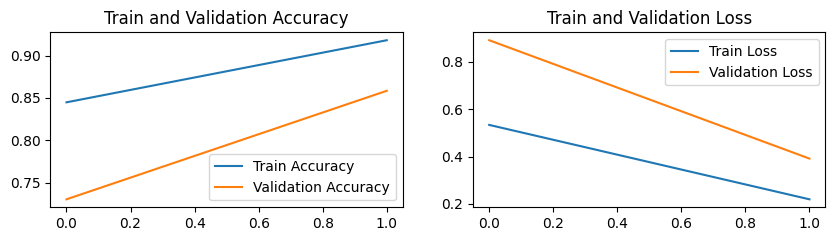

In [151]:
# Plot training and validation results
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Loss')

plt.show()

In [152]:
# evaluate model on validation
_, acc = model.evaluate(X_val, y_val, verbose=0)

print("Accuracy on validation set: {:.2f}%".format(acc*100))

Accuracy on validation set: 85.84%


In [153]:
# evaluate model on test
_, acc = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy on test set: {:.2f}%".format(acc*100))

Accuracy on test set: 87.03%


In [154]:
# evaluate model on training
_, acc = model.evaluate(X_train, y_train, verbose=0)

print("Accuracy on train set: {:.2f}%".format(acc*100))

Accuracy on train set: 84.39%


In [155]:
# Predict on val set
predictions = model.predict(X_val)
predictions = np.round(predictions)

19/19 [==============================] - 32s 2s/step


In [156]:
print("Predictions shape:", predictions.shape)
print("Predictions[:10]: ", predictions[:10])

Predictions shape: (586, 1)
Predictions[:10]:  [[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [157]:
print("y_val shape:", y_val.shape)
print("y_val[:10]: ", y_val[:10])

y_val shape: (586,)
y_val[:10]:  [1 1 1 1 0 1 1 1 1 0]


In [158]:
# Confusion matrix for val dataset
cm = confusion_matrix(y_val, predictions)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[159   3]
 [ 80 344]]


In [159]:
# Classification report for val dataset
print("Classification report:\n", classification_report(y_val, predictions, target_names=['Normal (Class 0)','Pneumonia (Class 1)']))

Classification report:
                      precision    recall  f1-score   support

   Normal (Class 0)       0.67      0.98      0.79       162
Pneumonia (Class 1)       0.99      0.81      0.89       424

           accuracy                           0.86       586
          macro avg       0.83      0.90      0.84       586
       weighted avg       0.90      0.86      0.86       586



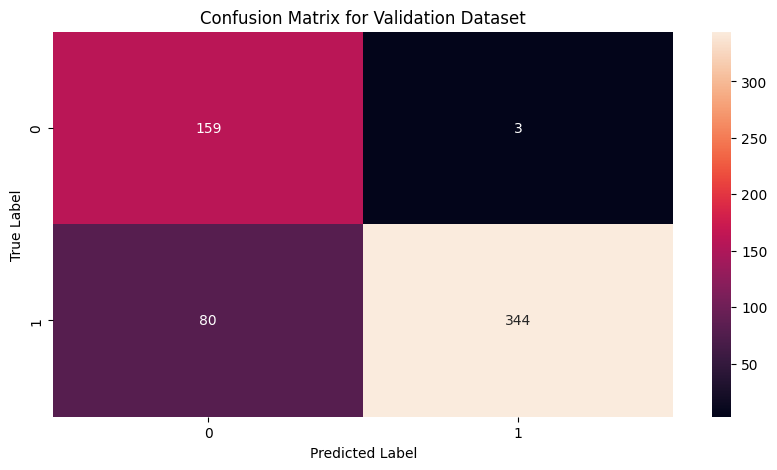

In [160]:
# Plot confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix for Validation Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [161]:
print("y_val shape:", y_val.shape)
print("y_val[:10]: ", y_val[:10])

y_val shape: (586,)
y_val[:10]:  [1 1 1 1 0 1 1 1 1 0]


In [162]:
# See which we predicted correctly and which not in val set

correct_indices = []
incorrect_indices = []

for i in range(len(predictions)):
    if predictions[i] == y_val[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


503  classified correctly
83  classified incorrectly


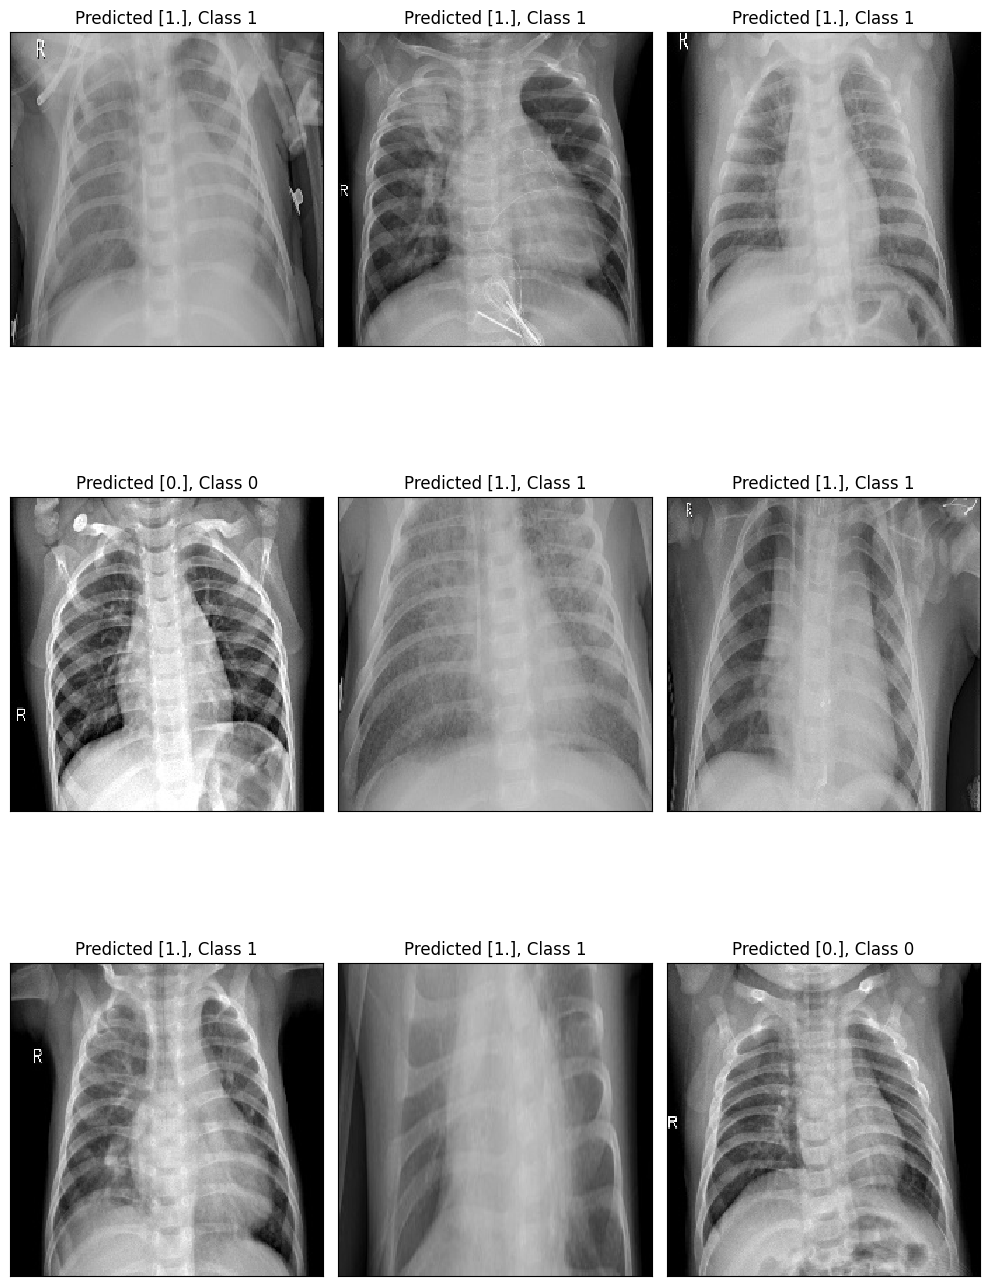

In [163]:
# Plot the first 9 correct predictions of val set
plt.figure(figsize=(10, 15))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_val[correct].reshape(224, 224, 3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predictions[correct], y_val[correct]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

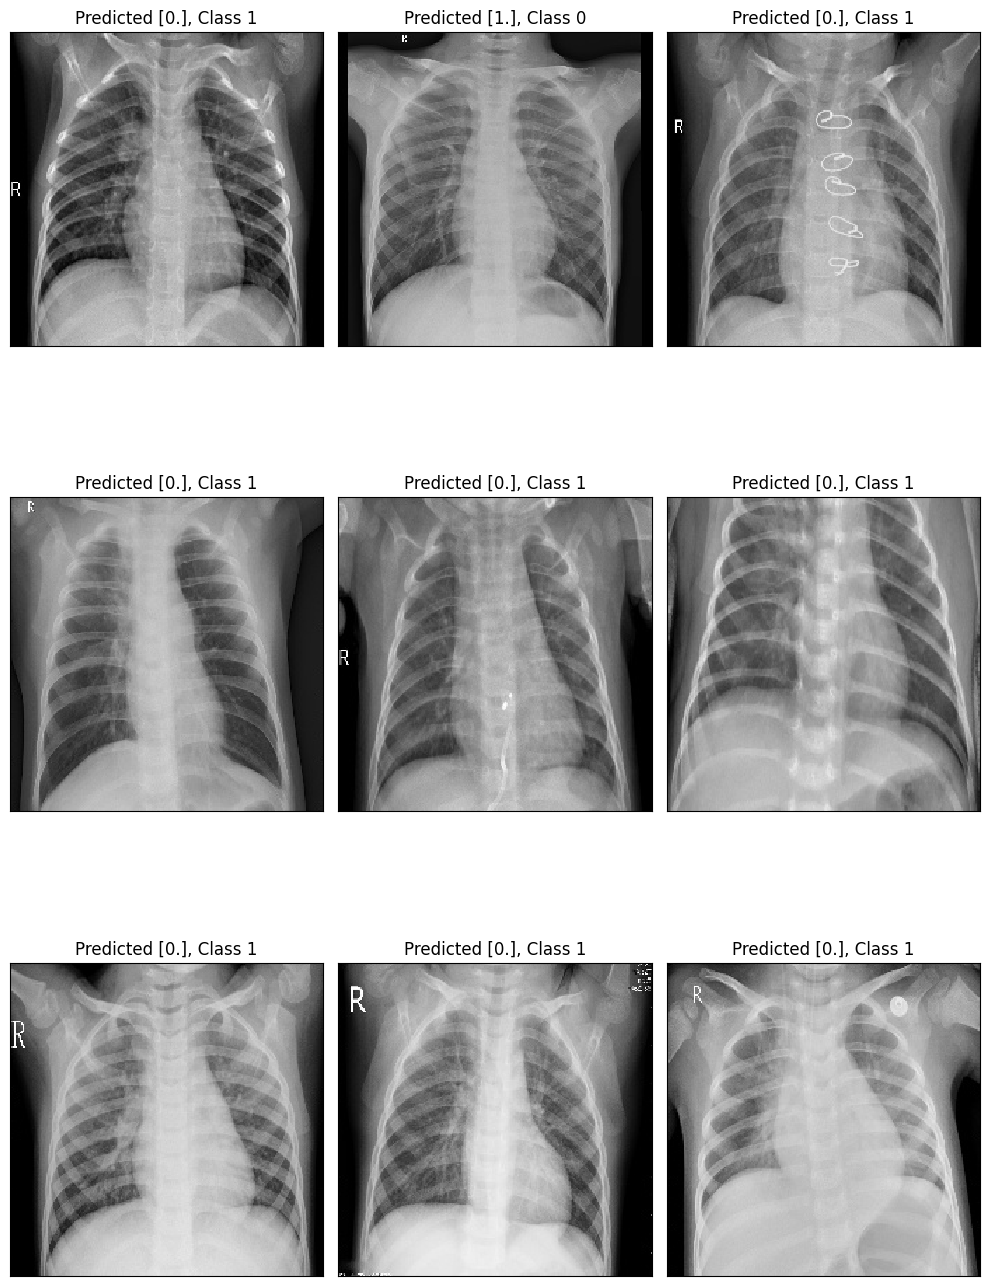

In [164]:
# Plot the first 9 incorrect predictions of val set
plt.figure(figsize=(10, 15))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_val[incorrect].reshape(224, 224, 3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predictions[incorrect], y_val[incorrect]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [165]:
# Predict on test set
predictions = model.predict(X_test)
predictions = np.round(predictions)

19/19 [==============================] - 35s 2s/step


In [166]:
print("Predictions shape:", predictions.shape)
print("Predictions[:10]: ", predictions[:10])

Predictions shape: (586, 1)
Predictions[:10]:  [[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [167]:
print("y_test shape:", y_test.shape)
print("y_test[:10]: ", y_test[:10])

y_test shape: (586,)
y_test[:10]:  [1 1 0 1 1 1 0 0 1 1]


In [168]:
# Confusion matrix for test dataset
cm = confusion_matrix(y_test, predictions)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[176   3]
 [ 73 334]]


In [169]:
# Classification report for test dataset
print("Classification report:\n", classification_report(y_test, predictions, target_names=['Normal (Class 0)','Pneumonia (Class 1)']))

Classification report:
                      precision    recall  f1-score   support

   Normal (Class 0)       0.71      0.98      0.82       179
Pneumonia (Class 1)       0.99      0.82      0.90       407

           accuracy                           0.87       586
          macro avg       0.85      0.90      0.86       586
       weighted avg       0.90      0.87      0.87       586



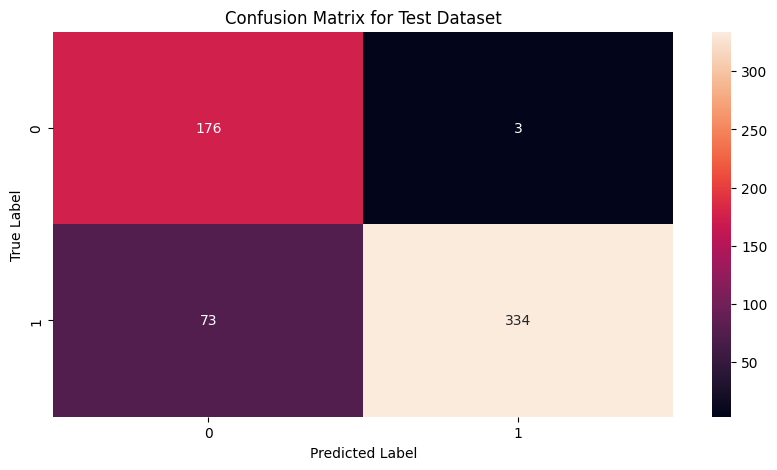

In [170]:
# Plot confusion matrix for test dataset
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix for Test Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [171]:
print("y_test shape:", y_test.shape)
print("y_test[:10]: ", y_test[:10])

y_test shape: (586,)
y_test[:10]:  [1 1 0 1 1 1 0 0 1 1]


In [172]:
# See which we predicted correctly and which not in test set

correct_indices = []
incorrect_indices = []

for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


510  classified correctly
76  classified incorrectly


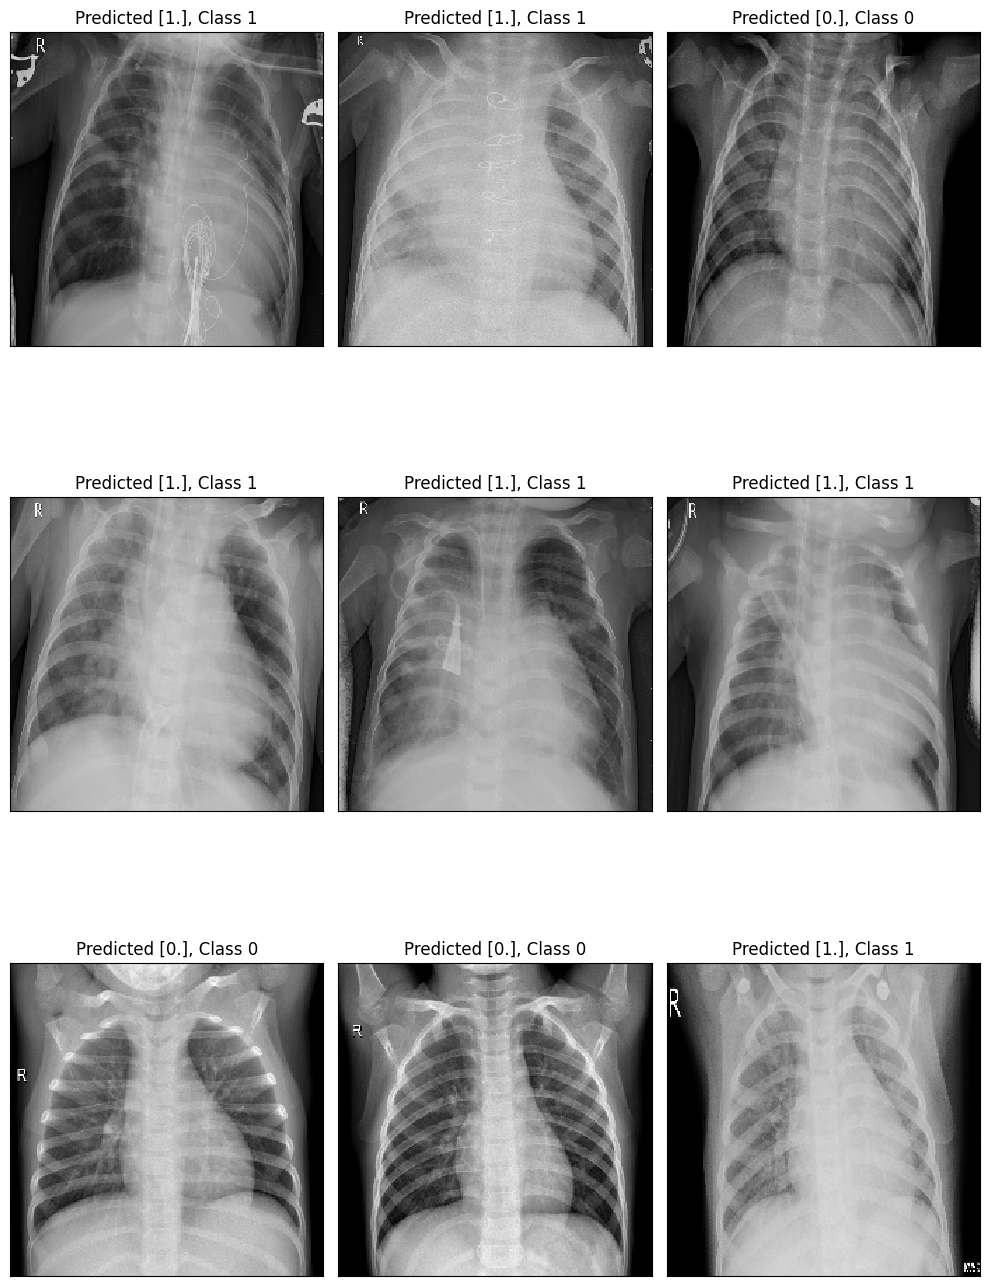

In [173]:
# Plot the first 9 correct predictions of test set
plt.figure(figsize=(10, 15))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[correct].reshape(224, 224, 3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predictions[correct], y_test[correct]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

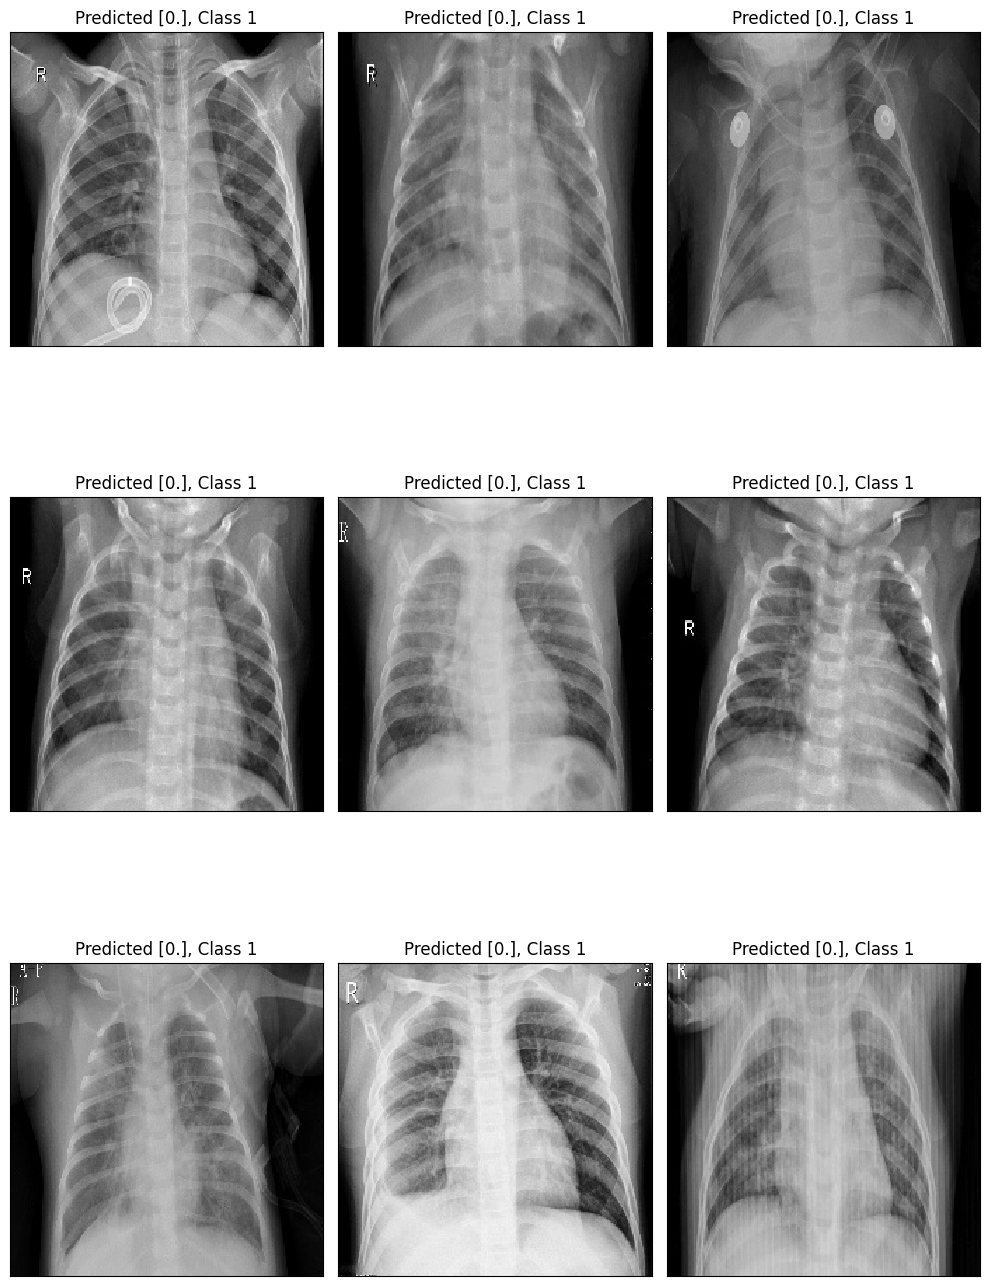

In [174]:
# Plot the first 9 incorrect predictions of test set
plt.figure(figsize=(10, 15))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[incorrect].reshape(224, 224, 3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predictions[incorrect], y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()